# t-SNE representation of +ve and -ve review of amazon product
# Bag of Words
Representation for BOW,TFIDF,AVGW2V,TFIDFW2V seperately for the review after converting to TDM
Dataset from: https://www.kaggle.com/snap/amazon-fine-food-reviews

Number of reviews: 568,454

Number of users: 256,059

Number of products: 74,258

Timespan: Oct 1999 - Oct 2012

Number of Attributes/Columns in data: 10 

Attribute Information:

Id

ProductId - unique identifier for the product

UserId - unqiue identifier for the user

ProfileName

HelpfulnessNumerator - number of users who found the review helpful

HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not

Score - rating between 1 and 5

Time - timestamp for the review

Summary - brief summary of the review

Text - text of the review

# Important
As the ram size is 6GB this analysis is done only with 2k+2k reviews were taken for uni+bigram analysis

# Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2) by dimension reduction so that it can be visualize by T-SNE

# Import data and libraries

In [2]:
from sklearn.manifold import TSNE
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

con = sqlite3.connect('database.sqlite') 

#get only +ve and -ve review 
filtered_data = pd.read_sql_query("""SELECT * FROM Reviews WHERE Score != 3""", con) 



# Data preprocessing

In [2]:
# Score>3 a positive rating, and score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

filtered_data.sample(5)
filtered_data['Score'].value_counts()

#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

#Deduplication of entries for same profilename,userid, time, text and take first element 
sorted_data=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)


In [3]:
#take only 5000 + 5000 data
clean_data=sorted_data.sample(frac=1).groupby('Score').head(2000)
clean_data['Score'].value_counts()

negative    2000
positive    2000
Name: Score, dtype: int64

In [4]:
# Clean html tag and punctuation

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

#substitute html tag and punctuation
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(sno.stem('tasty'))

tasti


In [5]:
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
#Create new catagory as Cleanedtext after removing htmltag and punctuation and uppercase and word length >2
for sent in clean_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (clean_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(clean_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    
    final_string.append(str1)
    i+=1

In [6]:
clean_data['CleanedText']=final_string
#store for future use
conn = sqlite3.connect('clean_data.sqlite')
c=conn.cursor()
conn.text_factory = str
clean_data.to_sql('Reviews1', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)



In [3]:
con = sqlite3.connect('clean_data.sqlite') 
clean_data = pd.read_sql_query("""SELECT * FROM Reviews1 WHERE Score != 3""", con) 

clean_data['CleanedText'].sample(15)

855     b'read miracl coconut oil though would call mi...
680     b'hard find small rawhid dog love great find p...
118             b'tast pretti good theyr greasi hot mild'
1452    b'know say either bad meat good chees well tru...
3821    b'even though appear intend dog bought cat dig...
260     b'weve tri sever differ type edibl chew lab la...
394     b'alway buy smaller pack target lover sooooo m...
494     b'chocol solo bar havent tast flavor far best ...
971     b'research gum found flavor crystal burn hurt ...
3220    b'review intend help buyer make intellig decis...
2578    b'anyon els notic mix ship without alfalfa mos...
1958    b'smell right tast way least use tri flavor mi...
513     b'want best tast popcorn oil bought gallon use...
1790    b'wife celiac stuff stand actual prefer regula...
1893    b'discov much like sauc visit london great get...
Name: CleanedText, dtype: object

In [4]:
#now convert CleanedText to TDM
count_vect = CountVectorizer() #in scikit-learn
final_counts = count_vect.fit_transform(clean_data['CleanedText'].values)

In [5]:
final_counts.get_shape()

(4000, 8625)

In [10]:
#Check some of th most common words
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

Most Common Positive Words :  [(b'tast', 863), (b'like', 838), (b'use', 737), (b'love', 714), (b'good', 708), (b'flavor', 690), (b'great', 647), (b'one', 593), (b'product', 569), (b'tea', 567), (b'tri', 531), (b'make', 480), (b'get', 453), (b'food', 439), (b'coffe', 426), (b'time', 375), (b'buy', 353), (b'find', 345), (b'would', 344), (b'eat', 330)]
Most Common Negative Words :  [(b'tast', 1233), (b'like', 1091), (b'product', 978), (b'flavor', 750), (b'one', 749), (b'would', 660), (b'tri', 616), (b'good', 508), (b'coffe', 501), (b'get', 490), (b'use', 488), (b'buy', 466), (b'food', 465), (b'tea', 447), (b'dont', 431), (b'order', 408), (b'even', 389), (b'box', 373), (b'bag', 369), (b'time', 349)]


In [8]:
# Create unigram and bigram TDM for 4k data and bigram taking a lot of time
#count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
count_vect = CountVectorizer()
final_bigram_counts = count_vect.fit_transform(clean_data['CleanedText'])
final_bigram_counts.get_shape()

(4000, 8625)

In [14]:
#final_bigram_counts.get_feature_names()
x = pd.DataFrame(final_bigram_counts.toarray())
type(final_bigram_counts)
type(x)

pandas.core.frame.DataFrame

In [15]:
#x=final_bigram_counts.toarray()

#x = pd.DataFrame(final_bigram_counts.todense(), columns=final_bigram_counts.get_feature_names())

y=clean_data['Score']
#print(y[1:2])
#print(stan_data.iloc[:,1:20])
print(x.shape)
print(y.shape)

(4000, 8625)
(4000,)


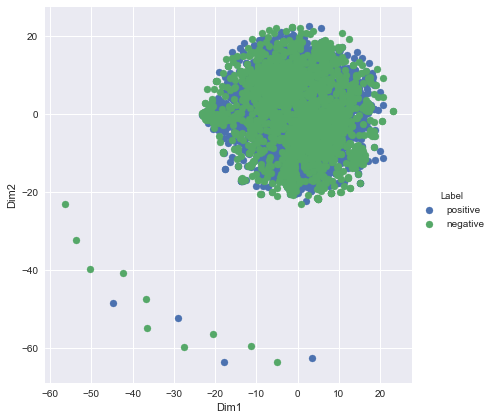

In [16]:
from sklearn.manifold import TSNE
#n_componets=2 means convert to 2D, and use perplexity = 10 points as near points, n_iter=2 iteration

model=TSNE(n_components=2,random_state=0)#,perplexity=10,n_iter=250)
tsne_data=model.fit_transform(x)
#create new data for plotting
tsne_data=np.vstack((tsne_data.T,y)).T
tsne_df=pd.DataFrame(data=tsne_data,columns=('Dim1','Dim2','Label'))
sns.FacetGrid(tsne_df,hue='Label',size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()
